### Empirical Example One for RobustiPY!

#### This example is designed to show how basic functionality -- such as OLS can be used with a cross-sectional dataset -- works.

Lets first load in two basic python libraries that we'll need for this example: the `os` module (for path handling), and `matplotlib.pyplot` (for plotting)

In [1]:
import os # for filepath handling
import requests # for grabbing the dataset
import matplotlib.pyplot as plt # for plotting

Let's make sure that we have RobustiPy installed. To do this (especially on Collab):

In [2]:
#%pip install git+https://github.com/robustipy/robustipy.git

Note next that this example uses the [union.dta](https://www.stata-press.com/data/r9/nlsw88.dta) dataset. This dataset is a subsample of the file National Longitudinal Survey of Young Women 88 data (Center for Human Resource Research 1989). Women were surveyed in each of the 21 years 1968–1988, except for the six years 1974, 1976, 1979, 1981, 1984, and 1986).

For more information on the NLS (see [http://www.bls.gov/nls/](http://www.bls.gov/nls/) or [https://www.nlsinfo.org/weights/nlsyw](https://www.nlsinfo.org/weights/nlsyw) for more details). Importantly, this dataset is entirely anonymised and publicly available.

Importantly for our purposes, it contains information on things like log-wage, union membership, and so forth.

Importantly, you should make sure that you have a copy of the [union.dta](https://www.stata-press.com/data/r17/union.dta) file located at somewhere like `.data\input`. We are not repackaging this dataset ourselves to be maximally respectful of all appropriate licenses at this time.n.

Now, let's load the two RobustiPy utils that we're going to need:

In [3]:
from robustipy.utils import prepare_union
from robustipy.models import OLSRobust

Our key objective is going to try to assess the effect of unionisation (i.e. our 'x' or '$\beta_1$' on wage. To do this, we'll vary various specifications along the way, and compare our results against other results in the literature\other statistical software.

Next, now that we've got this research question, robustipy installed, and our data set up, lets define a very simple function for this union example, and comment along as we go.

In [4]:
def union_example():
    """ A simple function for estimating the wage premium or
        penalty as a function of the NLSW1988 dataset using
        RobustiPy.

        Inputs: None
        Outputs: None
    """
    # First, lets grab our dataset:

   
    def get_nlsw88(url, path, fname):
        url = 'https://www.stata-press.com/data/r10/nlsw88.dta'
        response = requests.get(url, stream=True)
        
        if not os.path.exists(path):
            os.makedirs(path)
            print(f"Directory '{path}' and all required subdirectories created.")
        else:
            print(f"Directory '{path}' already exists.")
   
        if response.status_code == 200:
            with open(os.path.join(path, fname), 'wb') as f:
                for chunk in response.iter_content(chunk_size=8192):
                    f.write(chunk)
            print(f"File downloaded successfully and saved as {fname}")
        else:
            print(f"Failed to download the file. Status code: {response.status_code}")
    
            
    get_nlsw88('https://www.stata-press.com/data/r10/nlsw88.dta',
               os.path.join('data', 'input'), 'nlsw88.dta')
    
    
    # Then, lets make a simple function call which prepares this data akin with the best
    # practice econometric\statistical literature. This function comes wrapped inside 
    # RobustiPy as it's one of the headline examples of the library.

    # Importantly, we extract our: 'y' (dependent variable: wages),
    #                              'x' (indep. variable of interest: union membership)
    #                              'c' (our set of various controls).
    
    y, c, x, data = prepare_union(os.path.join('data',
                                               'input',
                                               'nlsw88.dta'
                                              )
                                 )

    # Now, lets make our first function call to RobustiPy, specifying x, y, and the dataset.

    union_robust = OLSRobust(y=[y], x=[x], data=data)

    # We're next going to 'Fit' our model, specifying: 'c'     (our set of various controls)
    #                                                  'draws' (the number of bootstraps we want)
    #                                                  'kfold' (the number of k-folds we want)
                    
    union_robust.fit(controls=c,
                     draws=1000,
                     kfold=10,
                     seed=192735,
                    )

    # Next, we want to get the results from this fit:
    
    union_results = union_robust.get_results()
    # Finally, we want to plot these results. The 'specs' command allows us to plot the values
    # from three specific pre-secified specifications (as a list of lists), as well as a
    # specific information criterion. We can also specify the figure size.
    
    union_results.plot(specs=[['hours', 'collgrad'],
                              ['collgrad'],
                              ['hours', 'age']],
                       ic='hqic',
                       ext='pdf',
                       project_name='union_example',
                       figsize=(16, 16)
                      )

    # Finally, save this figure o ut. First, set a (default) location:
    
    figpath = os.path.join(os.getcwd(), 'figures', 'union_example')

    # Check this path exists, if not, create it:
    
    if not os.path.exists(figpath):
        os.makedirs(figpath)

    # Finally, save the figure to that specific place as a .png file.
    plt.savefig(os.path.join(figpath, 'union_curve.svg'), bbox_inches='tight')
    
    return union_results

Great: now that we've defined our union plotting function, lets actually call it:

Directory 'data/input' already exists.


Output()

File downloaded successfully and saved as nlsw88.dta


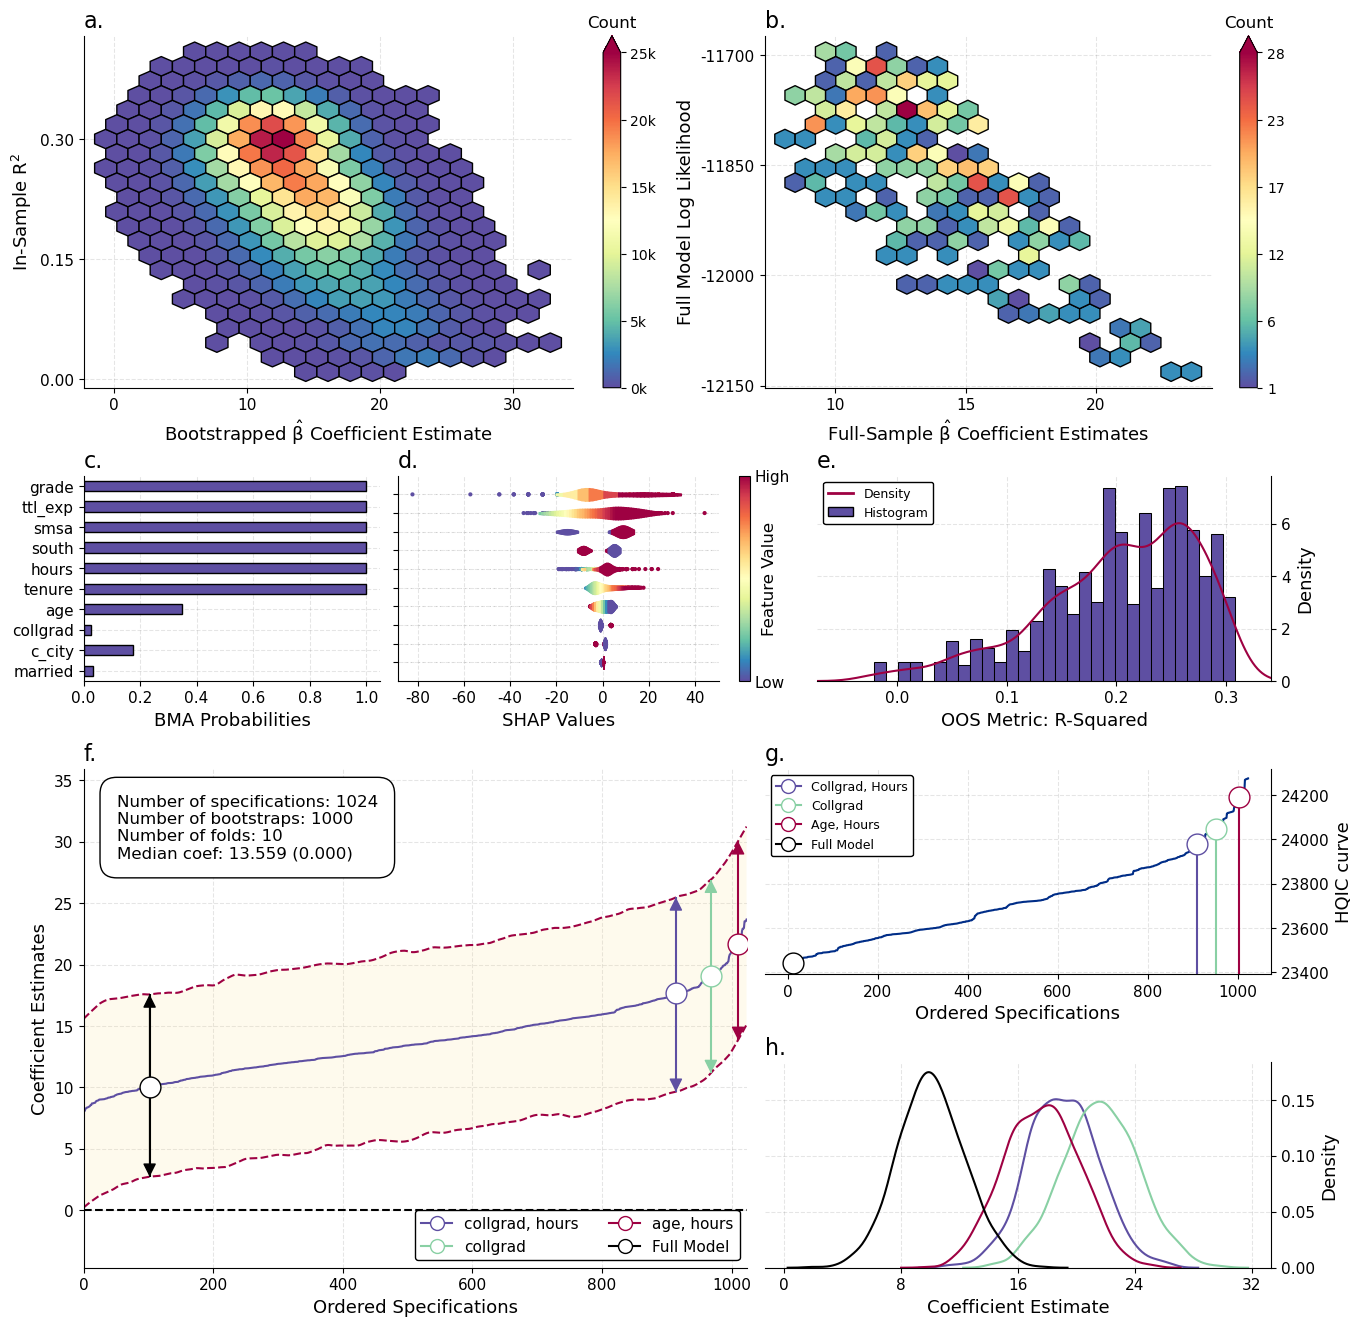

In [5]:
results = union_example()

In [6]:
results.summary()

1. Model Summary
Model: OLS Robust
Inference Tests: Yes
Dependent variable: log_wage
Independent variable: union
Number of possible controls: 10
Number of draws: 1000
Number of folds: 10
Number of specifications: 1024
2.Model Robustness Metrics
2.1 Inference Metrics
Median beta (all specifications, no resampling): 13.467211593121164 (p-value: 0.0)
Median beta (all bootstraps and specifications): 13.559222909705312
Min beta (all specifications, no resampling): 8.078911405415589
Min beta (all bootstraps and specifications): -0.630479645839813
Max beta (all specifications, no resampling): 23.652213184134595
Max beta (all bootstraps and specifications): 5.353590828261005
Significant portion of beta (all specifications, no resampling): 1.0 (p-value: 0.0)
Significant portion of beta (all bootstraps and specifications): 0.9939296875
Positive portion of beta (all specifications, no resampling): 1.0 (p-value: 0.0)
Positive portion of beta (all bootstraps and specifications): 0.999994140625
Nega

In [7]:
results.estimates

#shapes = [a.shape for a in results.all_b]
#print(shapes)

,0,1,2,3,4,5,6,7,8,9,...,990,991,992,993,994,995,996,997,998,999
0,22.439296,21.146900,22.866699,22.752992,22.006529,21.448626,24.918361,20.361170,20.474494,18.395577,...,21.447539,27.978139,25.644890,21.004279,22.374577,28.286779,27.069170,24.296409,21.637128,22.524342
1,26.660567,26.827991,20.817262,22.263013,22.324525,21.369101,25.119723,23.716005,21.563108,19.818508,...,22.293560,25.004335,21.697040,25.792161,17.607934,22.449388,18.651715,20.666758,26.431080,21.402267
2,22.637575,19.858663,23.812253,20.186156,17.595146,25.313957,18.848557,20.776320,21.921765,19.907846,...,21.859300,25.867694,16.254951,25.215082,23.975485,26.507102,24.098673,24.121794,22.054932,23.249837
3,18.229870,23.767010,18.439747,17.952908,11.822687,17.752984,17.990494,16.915892,15.821217,16.523568,...,15.339131,15.291257,15.680817,20.709464,18.701436,12.529012,20.247838,16.479679,18.190580,16.641442
4,20.158955,23.000895,18.905566,18.786178,17.297344,18.520195,19.463484,19.744904,22.043100,20.715415,...,18.165533,20.616018,20.137414,20.321960,22.995334,18.719432,14.083389,19.780718,26.352155,17.871648
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1019,9.825828,13.447743,14.238988,8.690585,13.106411,8.956925,11.272770,5.196905,9.918926,8.655442,...,14.113370,7.602504,8.954158,13.332573,8.873965,9.539104,9.916836,12.172383,8.391447,9.299010
1020,9.956324,10.052212,10.213837,10.549723,10.902929,10.597456,9.450762,7.956857,11.244384,9.441790,...,11.038317,10.534206,10.129347,11.281422,11.990853,14.774917,11.429508,9.744519,7.916611,12.652636
1021,13.391358,10.712420,6.026361,10.404401,6.546080,10.964514,13.451848,8.206500,10.571253,10.462269,...,10.231689,11.931342,12.142342,9.883630,7.265487,11.691050,7.563985,10.181899,11.344445,8.827844
1022,12.248657,13.228477,10.049254,12.308186,13.417456,13.932040,13.307665,13.774208,12.035411,10.658797,...,9.899623,9.852931,16.986318,12.342369,13.154201,11.265499,6.925620,12.735603,11.358662,11.125298


In [8]:
results.p_values

,0,1,2,3,4,5,6,7,8,9,...,990,991,992,993,994,995,996,997,998,999
0,5.573320e-14,9.161560e-13,6.661338e-15,2.864375e-14,5.440093e-14,2.751133e-13,0.000000e+00,1.560685e-11,7.329026e-12,8.662671e-10,...,3.230749e-13,0.000000e+00,0.000000e+00,2.208456e-12,1.565414e-13,0.000000e+00,0.000000e+00,0.000000e+00,7.397638e-12,4.904965e-13
1,0.000000e+00,0.000000e+00,1.674882e-12,7.194245e-14,2.842171e-14,1.115241e-11,0.000000e+00,0.000000e+00,3.130829e-14,1.340861e-11,...,1.256772e-13,0.000000e+00,5.417888e-14,0.000000e+00,3.158717e-09,2.042810e-14,3.026326e-10,8.484324e-13,0.000000e+00,5.973000e-14
2,4.130030e-14,3.386025e-11,4.440892e-16,2.331801e-11,2.272788e-09,2.220446e-16,9.062195e-11,1.479927e-12,1.803002e-13,3.178058e-11,...,1.011191e-12,0.000000e+00,7.055527e-08,0.000000e+00,6.439294e-15,0.000000e+00,0.000000e+00,2.220446e-16,1.279199e-12,1.219025e-13
3,9.070078e-12,0.000000e+00,5.124057e-11,2.160068e-10,2.409087e-05,7.194623e-10,1.198242e-11,2.225036e-10,8.212735e-09,1.720679e-09,...,9.215346e-09,3.889746e-08,2.807184e-08,1.287859e-14,1.604850e-11,5.987219e-06,5.151435e-13,4.209342e-09,4.125722e-11,9.338530e-10
4,5.771605e-12,0.000000e+00,5.521361e-12,8.344214e-12,1.426662e-09,3.235390e-11,2.863709e-12,3.783640e-12,1.088019e-14,2.391420e-13,...,4.653196e-10,2.334355e-12,1.199041e-13,8.866241e-13,4.862777e-14,2.439662e-10,1.046411e-06,1.058043e-12,0.000000e+00,3.815466e-10
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1019,9.412689e-05,4.749357e-08,7.174449e-08,8.023740e-04,2.587054e-07,6.382837e-04,9.427107e-06,4.933476e-02,9.516570e-05,1.138862e-03,...,9.044157e-09,1.971275e-03,4.153849e-04,4.996219e-08,8.630270e-04,7.036191e-05,3.693121e-05,3.398489e-06,7.727403e-04,1.612597e-04
1020,1.664548e-04,1.058764e-04,3.542184e-05,2.801611e-05,1.560436e-05,4.626875e-05,2.632538e-04,1.624429e-03,1.771231e-05,1.521408e-04,...,1.573217e-05,2.045846e-05,1.103064e-04,1.975877e-05,6.131013e-06,1.084382e-09,9.401562e-06,2.133273e-04,2.234847e-03,1.116267e-06
1021,7.956903e-08,6.097255e-05,1.793630e-02,8.303262e-05,1.021902e-02,2.628482e-05,9.917613e-08,1.317531e-03,3.987216e-05,3.354095e-05,...,5.395090e-05,5.879612e-06,2.760808e-06,1.565756e-04,2.765141e-03,5.663145e-06,1.503634e-03,5.592052e-05,8.924296e-06,3.409353e-04
1022,1.964008e-06,1.755546e-07,1.387939e-04,2.409233e-06,1.561839e-07,1.022651e-07,5.098682e-07,2.220946e-08,2.630763e-06,1.021835e-05,...,1.296461e-04,2.121161e-04,5.095924e-12,4.139681e-07,5.829905e-07,3.844560e-05,6.453492e-03,2.801459e-06,1.049725e-05,1.139324e-05


Ta da!